<a href="https://colab.research.google.com/github/marttech26/EY-Open-Science-Data-Challenge/blob/main/Challenge_2024_S2_NDVI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 2024 Open Science Data Challenge
### Sentinel-2 Vegetation Change with Cloud Filtering

This notebook calculates pixel-based vegetation change using Sentinel-2 optical data with cloud filtering. In order to identify regions where there is land change due to a tropical storm this code uses the Normalized Difference Vegetation Index (NDVI) which is commonly used to meausure vegetation extent and health. For example, this code will find areas where trees have fallen, tree leaves have been removed by high winds, grasslands have been flooded, or agriculture fields have been damaged. The outputs of this notebook can be used to identify storm-damaged vegetation areas and nearby regions that are likely to have significant building damage. The baseline data is [Sentinel-2 Level-2A](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a) data from the MS Planetary Computer catalog.

In [ ]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rasterio.features
import rioxarray as rio
import xrspatial.multispectral as ms
from matplotlib.cm import RdYlGn, Reds

# Import Planetary Computer tools
import pystac_client
import planetary_computer as pc
import odc
from odc.stac import stac_load
from odc.algo import to_rgba

### Load the satellite data

First, we define our area of interest using latitude and longitude bounds. This is the region where the data challenge is focused and where the most extensive damage can be found. GeoJSON format uses a specific order: (longitude, latitude), so be careful when entering the coordinates. Finally, we define the time window surrounding the storm landfall on September 20, 2017. Due to cloud cover, we will need to search well before and well after the storm to find good scenes with minimal cloud cover. As you will see, Puerto Rico is a very cloudy location.

In [ ]:
# Hurricane Maria - San Juan, Puerto Rico

# Define the bounding box for the entire data region
min_lon = -66.19385887
min_lat = 18.27306794
max_lon = -66.08007533
max_lat = 18.48024350

In [ ]:
# Calculate the bounds for doing an archive data search
bounds = (min_lon, min_lat, max_lon, max_lat)

In [ ]:
# Define the time window
time_window = "2017-07-01/2018-01-01"

Using the `pystac_client` we can search the Planetary Computer's STAC catalog for items matching our query parameters. The result is the number of scenes matching our search criteria that touch our area of interest. Some of these may be partial scenes and many will contain clouds.

In [ ]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
search = stac.search(collections=["sentinel-2-l2a"], bbox=bounds, datetime=time_window)
items = list(search.get_all_items())
print('This is the number of scenes that touch our region:',len(items))

This is the number of scenes that touch our region: 67


Next, we'll load the data into an [xarray](https://xarray.pydata.org/en/stable/) DataArray using the Open Data Cube (ODC) STAC [odc-stac](https://odc-stac.readthedocs.io/en/latest/index.html) library that is included with the Planetary Computer. The ODC [odc](https://www.opendatacube.org) is an open source geospatial data management and analysis software project that is used globally for many projects (e.g., Digital Earth Africa). The ODC-STAC code will load the selected items from the catalog search, select the desired spectral bands (including the SCL cloud filtering band), reproject into Lat-Lon coordinates (EPSG:4326) at 10-meters resolution (typical of Sentinel-2 pixel resolution), and clip the region to the spatial bounding box.

In [ ]:
# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
resolution = 10  # meters per pixel
scale = resolution / 111320.0 # degrees per pixel for CRS:4326

In [ ]:
xx = stac_load(
    items,
    bands=["red", "green", "blue", "nir", "SCL"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=pc.sign,
    bbox=bounds
)

In [ ]:
# View the dimensions of our XARRAY and the variables
display(xx)

<xarray.Dataset>
Dimensions:      (latitude: 2308, longitude: 1268, time: 35)
Coordinates:
  * latitude     (latitude) float64 18.48 18.48 18.48 ... 18.27 18.27 18.27
  * longitude    (longitude) float64 -66.19 -66.19 -66.19 ... -66.08 -66.08
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2017-07-07T15:07:41.026000 ... 2017-12...
Data variables:
    red          (time, latitude, longitude) uint16 dask.array<chunksize=(1, 2048, 1268), meta=np.ndarray>
    green        (time, latitude, longitude) uint16 dask.array<chunksize=(1, 2048, 1268), meta=np.ndarray>
    blue         (time, latitude, longitude) uint16 dask.array<chunksize=(1, 2048, 1268), meta=np.ndarray>
    nir          (time, latitude, longitude) uint16 dask.array<chunksize=(1, 2048, 1268), meta=np.ndarray>
    SCL          (time, latitude, longitude) uint16 dask.array<chunksize=(1, 2048, 1268), meta=np.ndarray>

### View RGB (real color) images from the time series
You will notice that many of the scenes have clouds and some of the scenes are "clipped" due to scene boundaries. In general we want to look for scenes that fill the ROI bounds with clear data. Also, these images are merely for quick review and are not scaled correctly to reflect the proper Lat-Lon ratios. Finally, the numbering for these scenes starts at ZERO and goes from the top-left across the rows to reach the total number of scenes in the data array shown above.

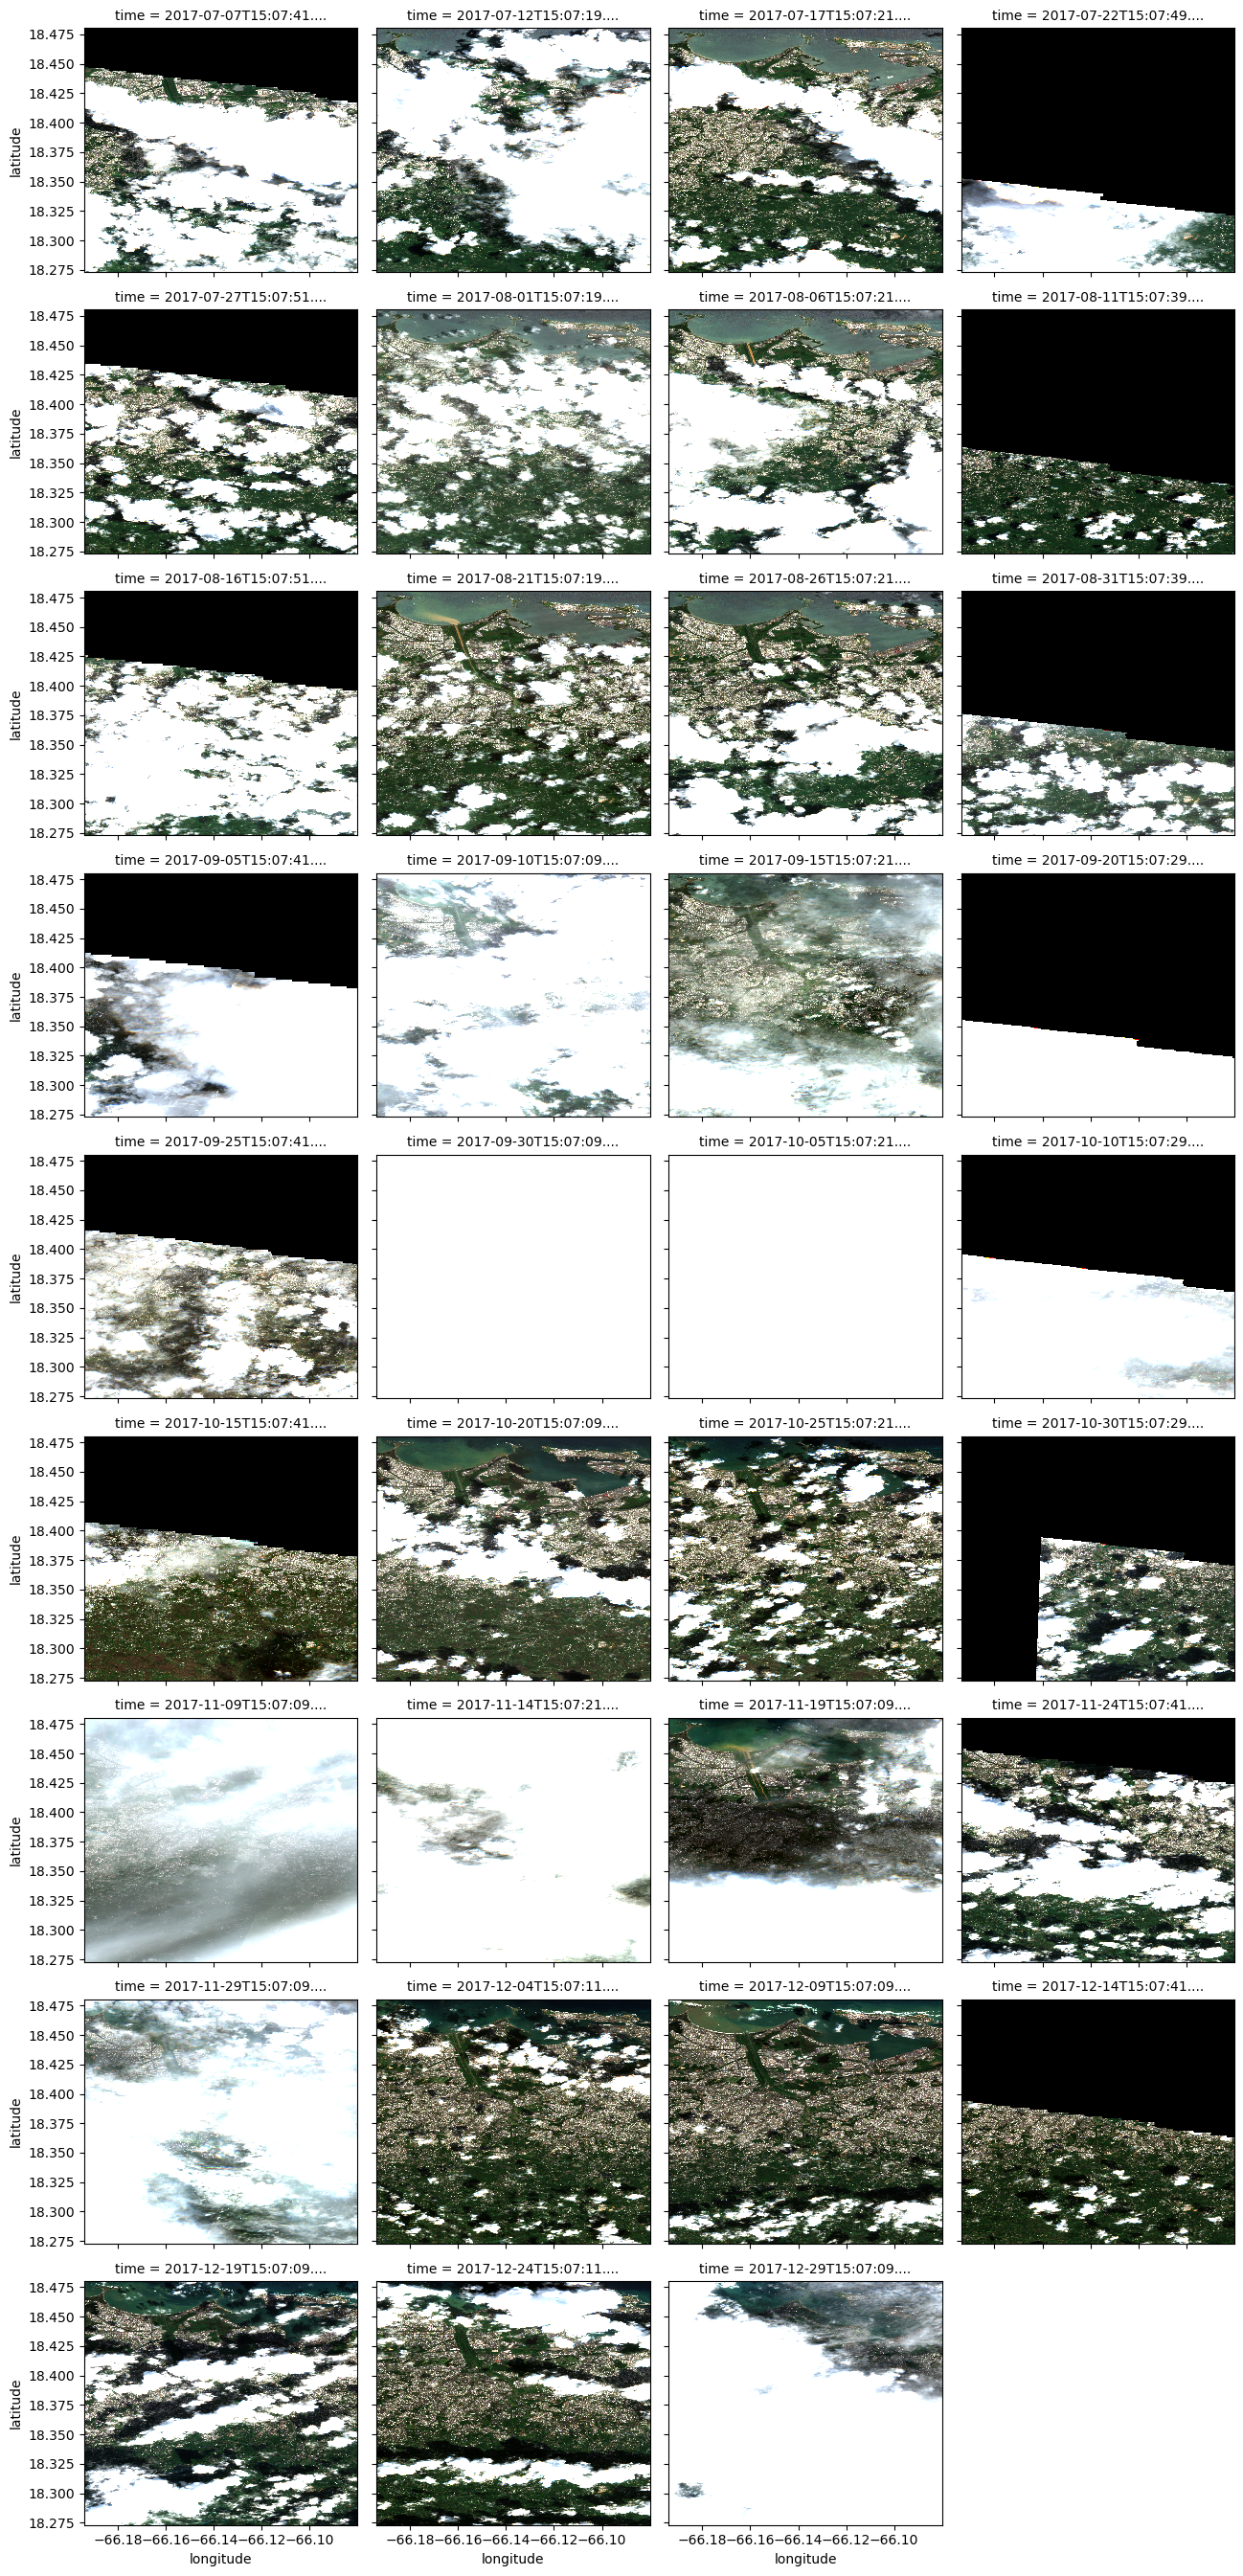

In [ ]:
plot_xx = xx[["red","green","blue"]].to_array()
plot_xx.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=3000)
plt.show()

In [ ]:
# Select a time slice to view a simgle RGB image and the cloud mask
# See the XARRAY dimensions above for the number of time slices (starts at 0)

time_slice = 29 # December 9, 2017 (post-storm)

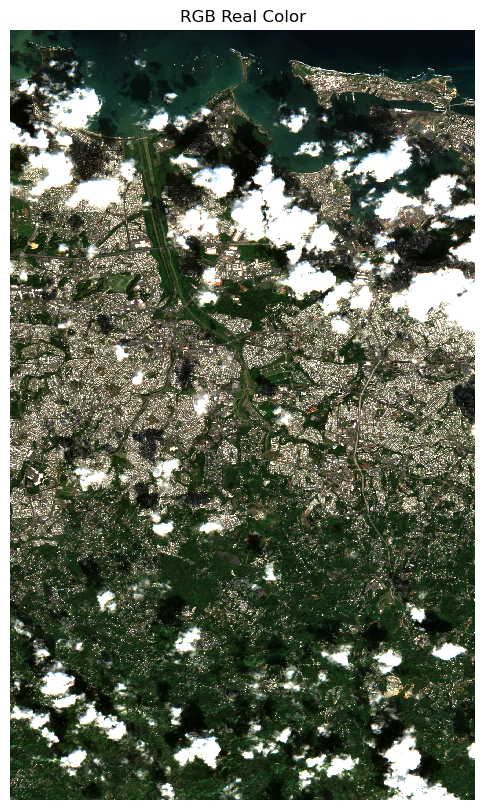

In [ ]:
# Plot an RGB Real Color Image for a single date
fig, ax = plt.subplots(figsize=(6,10))
xx.isel(time=time_slice)[["red", "green", "blue"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0, vmax=3000)
ax.set_title("RGB Real Color")
ax.axis('off')
plt.show()

### Apply Cloud Filtering and Masking

In [ ]:
# Filter data using the Sentinel-2 SCL band classification

# scl=0 > No Data
# scl=1 > Saturated
# scl=3 > Cloud Shadows
# scl=6 > Water
# scl=8 > Cloud Medium Probability
# scl=9 > Cloud High Probability
# scl=10 > Thin Cirrus Cloud

In [ ]:
# Create a colormap to display the SCL pixel classifications

scl_colormap = np.array(
    [
        [252,  40, 228, 255],  # 0  - NODATA - MAGENTA
        [255,   0,   4, 255],  # 1  - Saturated or Defective - RED
        [0  ,   0,   0, 255],  # 2  - Dark Areas - BLACK
        [97 ,  97,  97, 255],  # 3  - Cloud Shadow - DARK GREY
        [3  , 139,  80, 255],  # 4  - Vegetation - GREEN
        [192, 132,  12, 255],  # 5  - Bare Ground - BROWN
        [21 , 103, 141, 255],  # 6  - Water - BLUE
        [117,   0,  27, 255],  # 7  - Unclassified - MAROON
        [208, 208, 208, 255],  # 8  - Cloud - LIGHT GREY
        [244, 244, 244, 255],  # 9  - Definitely Cloud - WHITE
        [195, 231, 240, 255],  # 10 - Thin Cloud - LIGHT BLUE
        [222, 157, 204, 255],  # 11 - Snow or Ice - PINK
    ],
    dtype="uint8",
)

In [ ]:
def colorize(xx, colormap):
    return xr.DataArray(colormap[xx.data], coords=xx.coords, dims=(*xx.dims, "band"))

In [ ]:
cloud_mask = (xx.SCL != 0) & (xx.SCL != 1) & (xx.SCL != 3) & (xx.SCL != 6) & (xx.SCL != 8) & (xx.SCL != 9) & (xx.SCL != 10)

In [ ]:
# Apply cloud mask ... NO Clouds, NO Cloud Shadows and NO Water pixels
# All masked pixels are converted to "No Data" and stored as 16-bit integers
cleaned_data = xx.where(cloud_mask).astype("uint16")

In [ ]:
# Load SCL band, then convert to RGB using color scheme above
scl_rgba_clean = colorize(cleaned_data.isel(time=time_slice).SCL.compute(), scl_colormap)

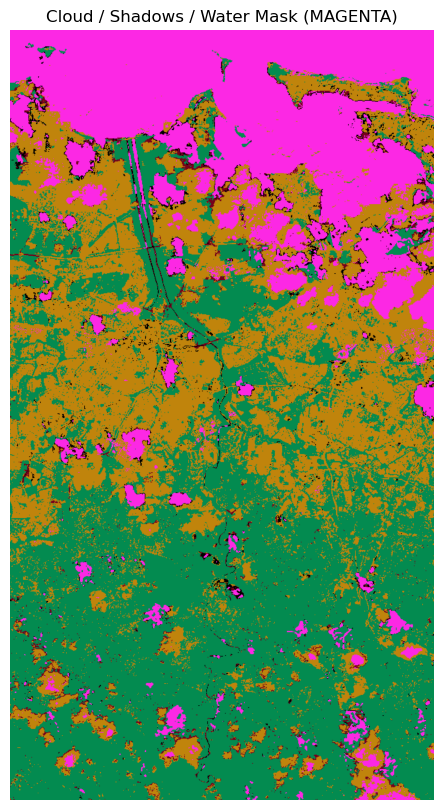

In [ ]:
# Create an RGB plot of the SCL band
# Masked data (clouds/shadows/water) are shown in MAGENTA

plt.figure(figsize = (6,10))
plt.imshow(scl_rgba_clean)
plt.title("Cloud / Shadows / Water Mask (MAGENTA)")
plt.axis('off')
plt.show()

### Normalized Difference Vegetation Index (NDVI)

The <b>Normalized Difference Vegetation Index (NDVI)</b> is used to measure the "greenness" of vegetation and has a range of 0.0 to 1.0. Low values (0.0 to 0.25) reflect a lack of vegetation (bare soil, water, trees without leaves), middle values (0.25 to 0.6) reflect grasslands or light vegetation, and high values (0.6 to 1.0) reflect dense forests. The equation uses two spectral bands where: <b>NDVI = (NIR-Red) / (NIR+Red).

In [ ]:
# Define the two time steps to view and compare NDVI outputs
first_time = 2 # July 17, 2017
second_time = 29 # December 9, 2017

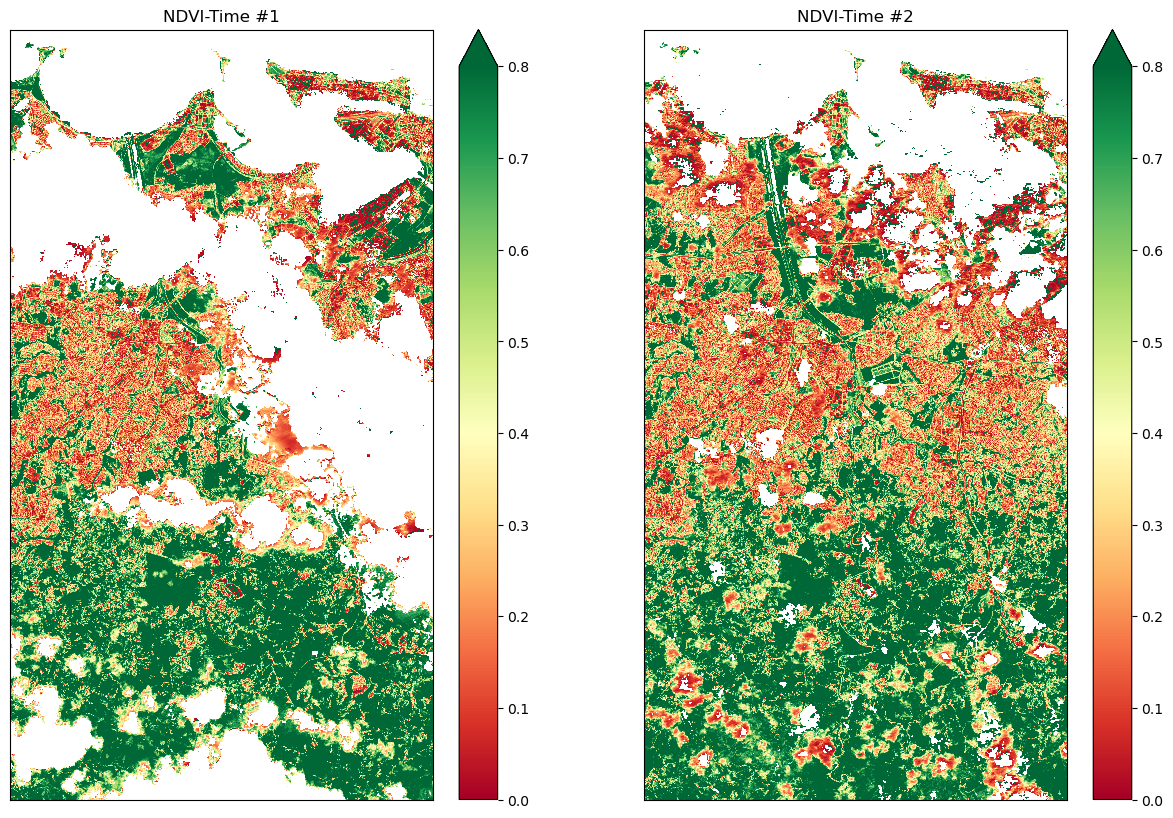

In [ ]:
# Plots of NDVI at two different time slices
# Clouds, Shadows and Water are masked

fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ndvi_image = (cleaned_data.nir-cleaned_data.red)/(cleaned_data.nir+cleaned_data.red)
ndvi_image.isel(time=first_time).plot(ax=ax[0], vmin=0.0, vmax=0.8, cmap="RdYlGn")
ndvi_image.isel(time=second_time).plot(ax=ax[1], vmin=0.0, vmax=0.8, cmap="RdYlGn")
ax[0].set_title('NDVI-Time #1'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('NDVI-Time #2'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
plt.show()

### NDVI Change Product
Calculate an NDVI anomaly by comparing the two images. Mask all areas of clouds and water that part of either image.

In [ ]:
def NDVI(dataset):
    return (dataset.nir - dataset.red)/(dataset.nir + dataset.red)

In [ ]:
ndvi_clean = NDVI(cleaned_data)

In [ ]:
ndvi_pre = ndvi_clean.isel(time=first_time)
ndvi_post = ndvi_clean.isel(time=second_time)
ndvi_anomaly = ndvi_post - ndvi_pre

In [ ]:
# Set colormap values for mask
# All areas of water or clouds will be black
RdYlGn.set_bad('black',1.)

In [ ]:
# Reverse the colormap for reds
Reds_reverse = "Reds_r"

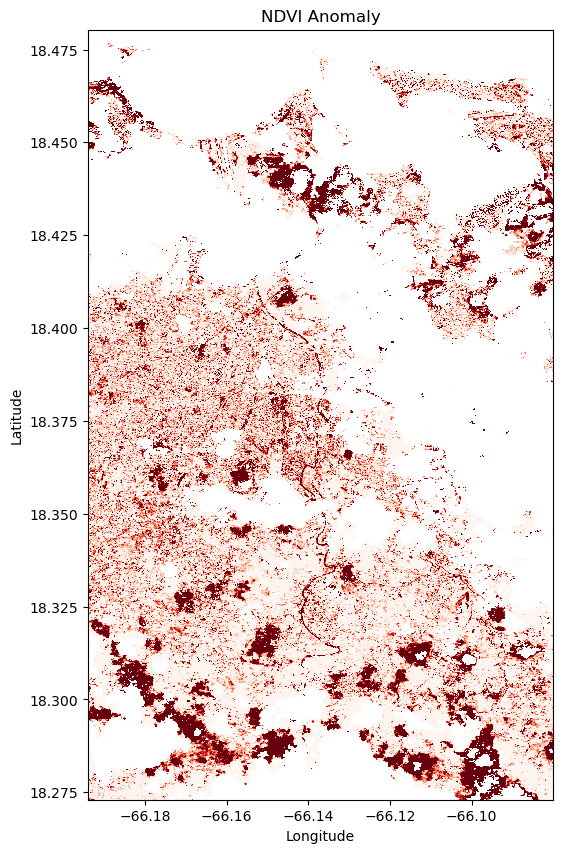

In [ ]:
## Plot NDVI Anomaly
plt.figure(figsize = (6,10))
ndvi_anomaly.plot(vmin = -0.2, vmax=0.0, cmap = Reds_reverse, add_colorbar=False)
plt.title("NDVI Anomaly")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
# plt.axis('off')
plt.show()

<b>COMMENTS ON RESULTS:</b> The results above show many areas where vegetation has been lost or severely reduced. These areas have a reduced NDVI value of 0.2 or more given a normal range of 0 to 1.0. This amount of loss is typical for severe vegetation change due to a storm or fire. Areas of white color are masked regions where there are clouds or water in either image. As you can see, there are many clouds in these images but they represent the best available images before and after the storm. It is also important to note that Puerto Rico has a consistent annual climate so vegetation change during a year is minimal. Therefore, it is possible to compare images from different times of the year and still detect valid change. So, how might participants use this data? Buildings near areas where there is significant land change (dark red) are likely to see some of the highest levels of damage.